In [ ]:
import pandas as pd
import numpy as np
import joblib
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import re
import string

import nltk
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import precision_score, confusion_matrix, recall_score, f1_score
from sklearn.metrics import classification_report

from catboost import CatBoostClassifier, Pool


# Загрузка данных

In [3]:
data = pd.read_csv('data\Restaurant reviews.csv')

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\User\AppData\Local\Temp\ipykernel_2616\1978199797.py:1: SyntaxWarning: invalid escape sequence '\R'
  data = pd.read_csv('data\Restaurant reviews.csv')


In [4]:
data.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


В данном проекте будем проводить анализ тональности отзывов. То есть нужны колонки только с текстом отзывам и рейтингом

In [5]:
data = data[['Review', 'Rating']]

In [6]:
data.head()

,Review,Rating
0,"The ambience was good, food was quite good . h...",5
1,Ambience is too good for a pleasant evening. S...,5
2,A must try.. great food great ambience. Thnx f...,5
3,Soumen das and Arun was a great guy. Only beca...,5
4,Food is good.we ordered Kodi drumsticks and ba...,5


# EDA и обработка текста

In [7]:
data.describe()

,Review,Rating
count,9955,9962
unique,9364,10
top,good,5
freq,237,3832


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  9955 non-null   object
 1   Rating  9962 non-null   object
dtypes: object(2)
memory usage: 156.4+ KB


Рассмотрим распределение оценок 

In [9]:
data.Rating.value_counts()

Rating
5       3832
4       2373
1       1735
3       1193
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: count, dtype: int64

Оказалось, что рейтинг не обязательно целое число. Так же нашёлся один отзыв с оценкой "Like". Заменим его на 5.

In [10]:
data.loc[data['Rating'] == 'Like', 'Rating'] = '5'

In [11]:
data['Rating'] = data['Rating'].astype(float)

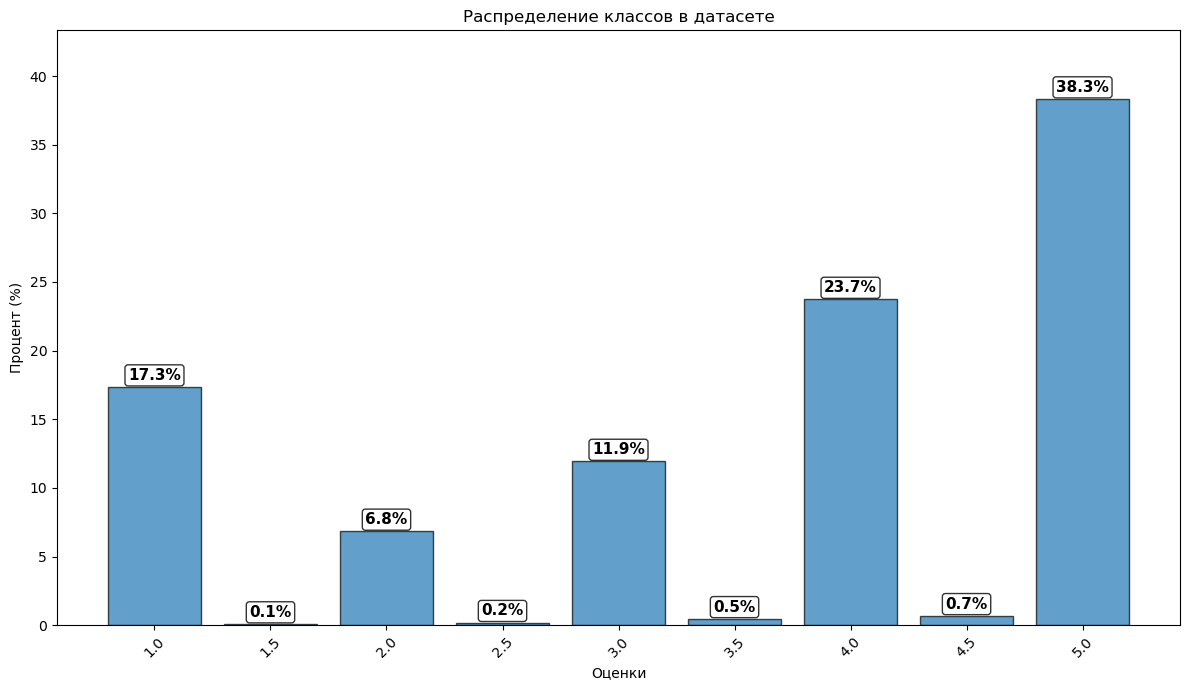

In [12]:
def draw_target_percents(data, target, label):
    percent_class = (data[target].value_counts() / data.shape[0] * 100)
    percent_class = percent_class.sort_index()
    class_names = percent_class.index
    percentages = percent_class.values
    plt.figure(figsize=(12, 7))
    bars = plt.bar(class_names, percentages, edgecolor='black', alpha=0.7, width=[0.4 for _ in range(len(class_names))])
    for bar, percentages in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{percentages:.1f}%', 
                ha='center', va='bottom', 
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    plt.xticks(class_names, rotation=45)  # rotation для наклона подписей

    plt.xlabel('Оценки')
    plt.ylabel('Процент (%)')
    plt.title('Распределение классов в датасете')
    plt.ylim(0, percentages.max() + 5)
    plt.tight_layout()  # Важно для корректного отображения
    plt.show()
draw_target_percents(data, 'Rating', 'Rating')

Больше всего положительных отзывов. Так как много классов с малым содержанием объектов объеденим несколько классов в один. 
- $< 3$  негативные отзывы, 
- $3-4$ - нейтральные, 
- $ >= 4$ - положительные

In [13]:
def recode_values(x):
    
    if x < 3:
        return 1
    elif 3 <= x < 4:
        return 2
    else:  # x >= 4
        return 3
data['Rating'] = data['Rating'].apply(recode_values)

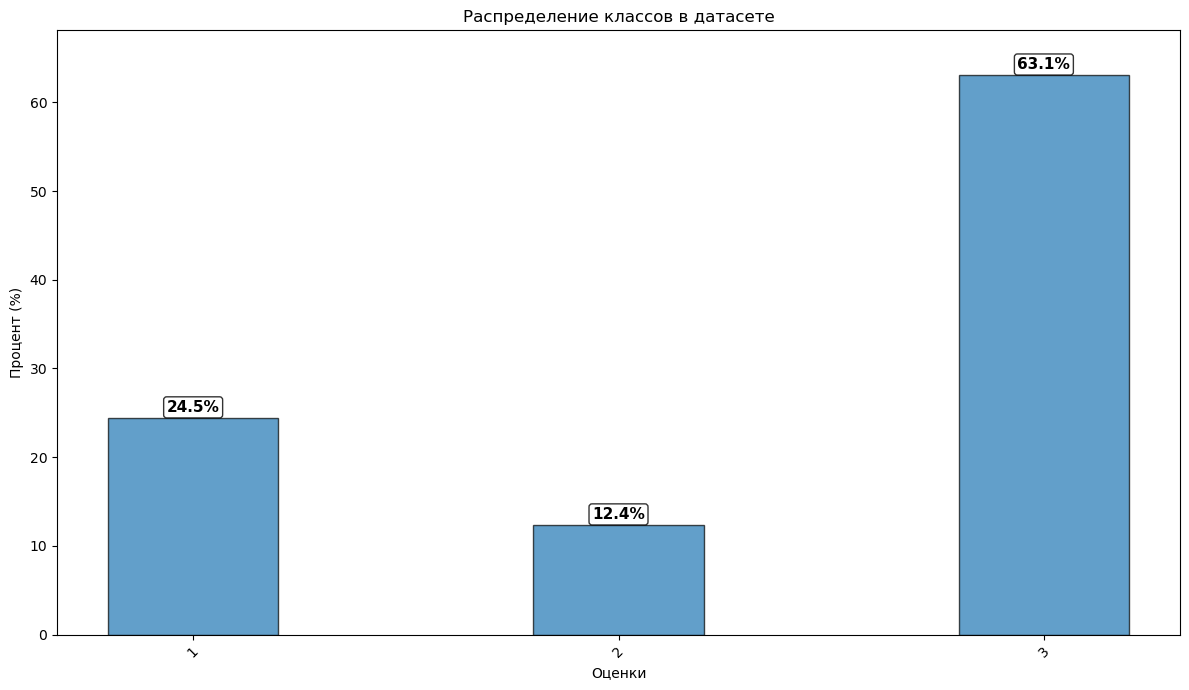

In [14]:
draw_target_percents(data, 'Rating', 'Rating')

Есть существенный дисбаланс классов в сторону положительных отзывов

## Предобработка текста

Проведём предобработку теста:
- Удалим все знаки пунктуации
- Стоп слова
- Ссылки, Хештеги
- Числа

In [15]:
# nltk.download('punkt_tab')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

class EnglishTextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        
       
        self.stop_words.update(['get', 'would', 'could', 'also', 'us', 'go', 'like'])
    
    def clean_text(self, text):
        if not isinstance(text, str) or not text.strip():
            return ""
        
        # 1. Приведение к нижнему регистру
        text = text.lower()
        
        # 2. Удаление HTML-тегов
        text = re.sub(r'<.*?>', ' ', text)
        
        # 3. Удаление URL
        text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
        
        # 4. Удаление email
        text = re.sub(r'\S+@\S+', ' ', text)
        
        # 5. Удаление цифр
        text = re.sub(r'\d+', ' ', text)
        
        # 6. Удаление пунктуации (сохраняем апострофы для слов типа "don't")
        text = re.sub(r'[^\w\s\']', ' ', text)
        
        # 7. Удаление лишних пробелов
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize(self, text):
        return word_tokenize(text)
    
    def remove_stopwords(self, tokens):
        return [token for token in tokens if token not in self.stop_words and len(token) > 2]
    
    def lemmatize_tokens(self, tokens):
        return [self.lemmatizer.lemmatize(token) for token in tokens]
    
    def stem_tokens(self, tokens):
        return [self.stemmer.stem(token) for token in tokens]
    
    def preprocess_pipeline(self, text, use_lemmatization=True):
        cleaned_text = self.clean_text(text)
        if not cleaned_text:
            return []
        
        tokens = self.tokenize(cleaned_text)
        tokens = self.remove_stopwords(tokens)
        
        if use_lemmatization:
            tokens = self.lemmatize_tokens(tokens)
        else:
            tokens = self.stem_tokens(tokens)
        
        return tokens

In [16]:
def cleanText(df, text_column, new_column='processed_text'):
    preprocessor = EnglishTextPreprocessor()
    
    df[new_column] = df[text_column].apply(
        lambda x: ' '.join(preprocessor.preprocess_pipeline(x, use_lemmatization=True)) 
        if isinstance(x, str) else ''
    )
    return df

In [17]:
processedData = cleanText(data, 'Review', 'CleanReview')

In [18]:
processedData.head()

,Review,Rating,CleanReview
0,"The ambience was good, food was quite good . h...",3,ambience good food quite good saturday lunch c...
1,Ambience is too good for a pleasant evening. S...,3,ambience good pleasant evening service prompt ...
2,A must try.. great food great ambience. Thnx f...,3,must try great food great ambience thnx servic...
3,Soumen das and Arun was a great guy. Only beca...,3,soumen da arun great guy behavior sincerety go...
4,Food is good.we ordered Kodi drumsticks and ba...,3,food good ordered kodi drumstick basket mutton...


Отрисуем самые популярные слова для каждой категории оценок.

In [19]:
def generate_wordcloud_from_processed(df, text_column, title="Word Cloud"):

    
    all_text = ' '.join(df[text_column].dropna().astype(str))
    
    
    wordcloud = WordCloud(
        width=1200,
        height=600,
        background_color='white',
        max_words=150,
        colormap='viridis',
        random_state=42,
        collocations=False,  
        min_font_size=10,
        max_font_size=120
    ).generate(all_text)
    
    # Рисуем
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, pad=20)
    plt.tight_layout()
    plt.show()
    
    return wordcloud

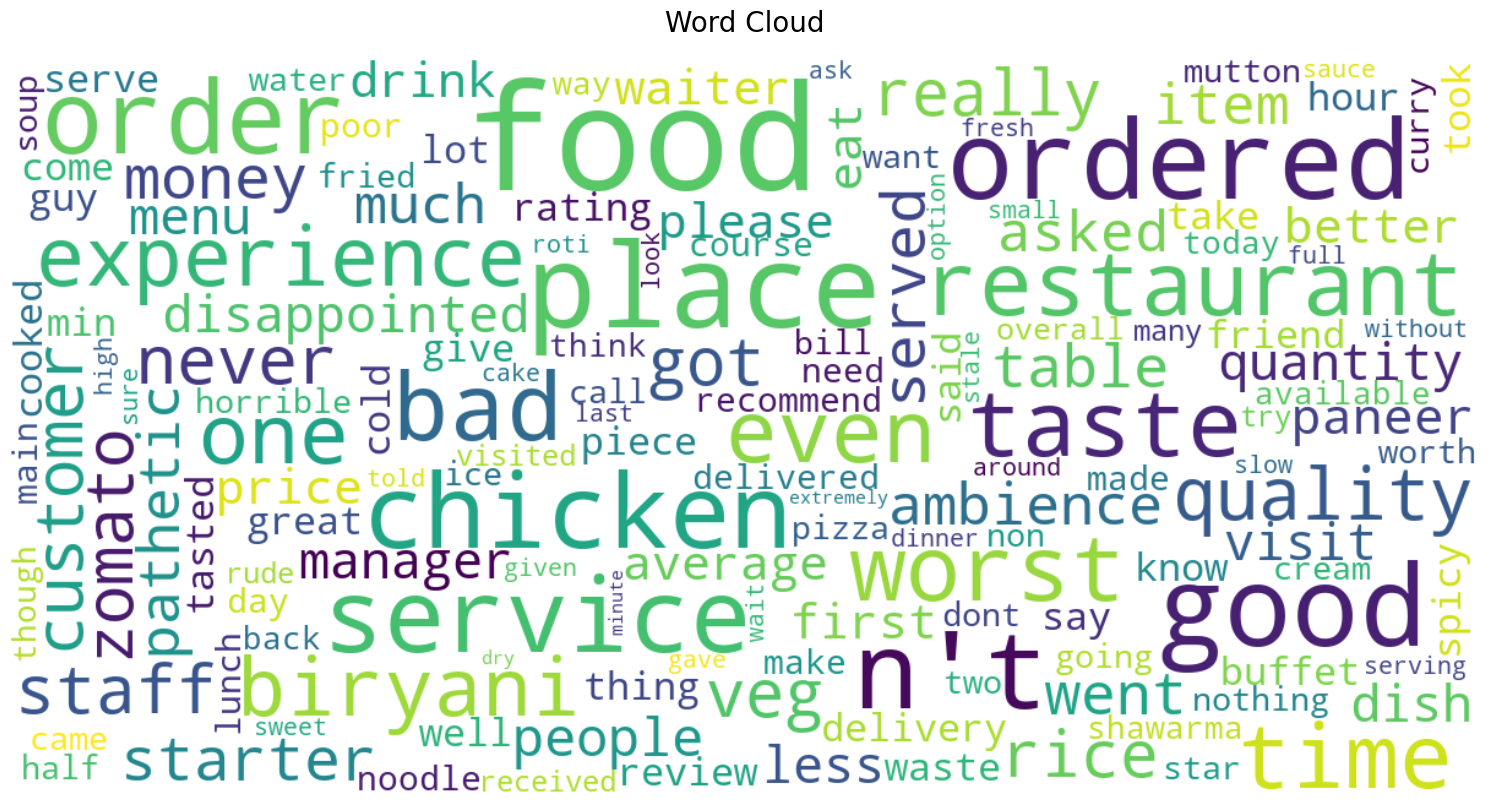

In [20]:
generate_wordcloud_from_processed(processedData[processedData['Rating'] == 1], 'CleanReview')

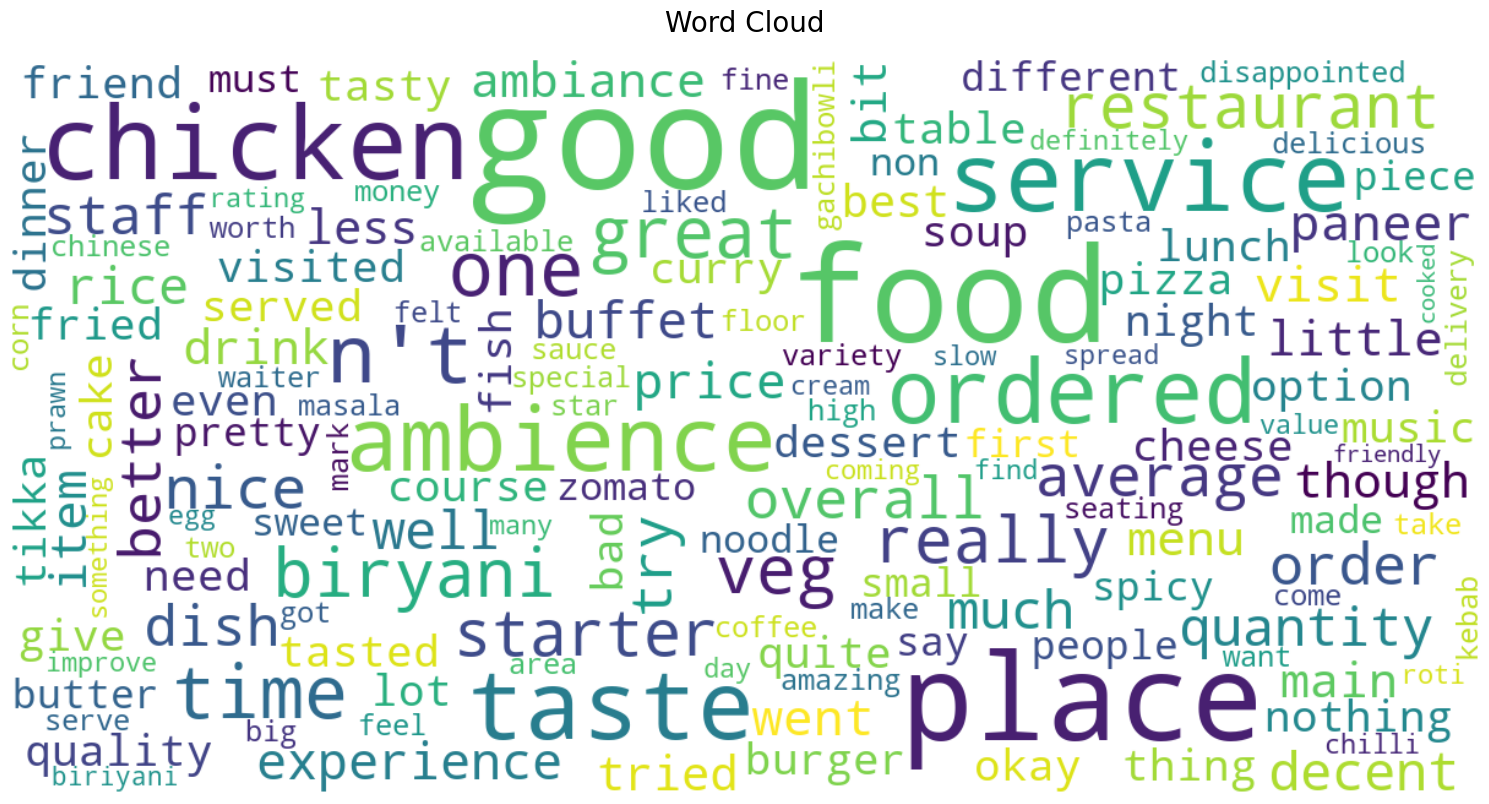

In [21]:
generate_wordcloud_from_processed(processedData[processedData['Rating'] == 2], 'CleanReview')

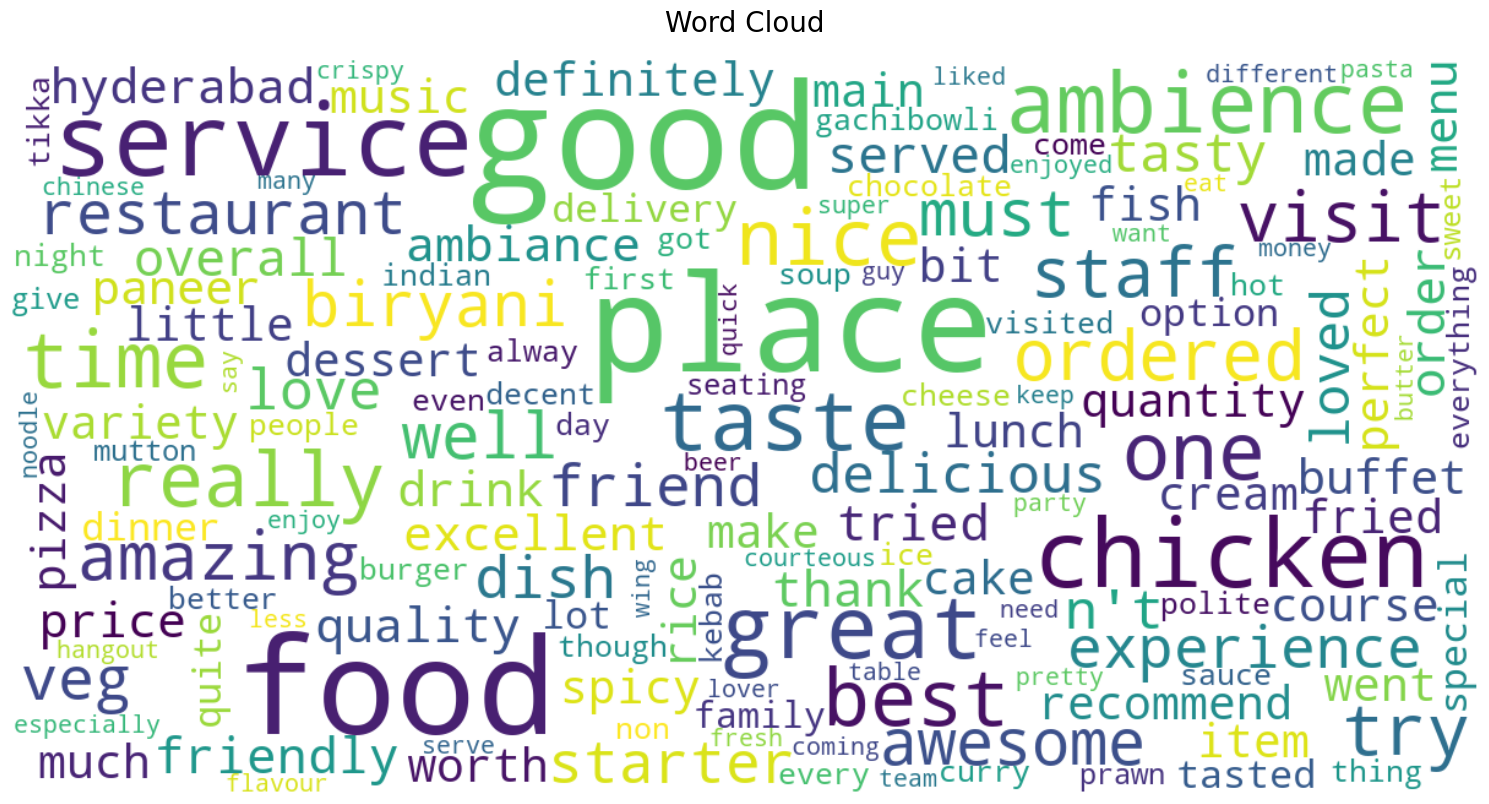

In [22]:
generate_wordcloud_from_processed(processedData[processedData['Rating'] == 3], 'CleanReview')

Выводы: На всех облаках слов доминируют слова food, place, service. Можно сделать вывод, что это самые главные критерии для людей. 
- Но на облаке слов для отрицательных отзывов очень много негативных прилагательных. Присуствуют и положительные, но надо учитывать, что так же на картинке очень большой вес имеет отрицание. Поэтому, скорее всего, эти прилагательные шли в паре с отрицаинием и несут негативную окраску для отзыва.

- Для нейтральных отзывов уже почти отсутсвуют негативные прилагательные, а больше спокойных выражений. 

- Для положительных отзывов заметно доминирование сильно  хвалебных прилагательных, а так же глаголов (visit, recommend)

Так же можно подметить, что слова связанные с ценой имеют не самый большой вес, но для положительных и нейтральных отзывов заметный. А в положительных отзывах слова связанные с деньгами очень маленькие. Значит люди готовы платить за качественную еду и сервис, но если им что-то не понравится они обратят внимание на ценники.  

Для более глубокого понимания, оценим топ 10 самых популярных слов числено. 

In [23]:
def plot_top_words_bar(df, text_column,  title, top_n=10, figsize=(12, 8)):
    all_tokens = []
    for text in df[text_column].dropna():
        if isinstance(text, str) and text.strip():
            all_tokens.extend(text.split())
    
    word_freq = Counter(all_tokens)
    top_words = word_freq.most_common(top_n)
    
    
    words, counts = zip(*top_words)
    
   
    plt.figure(figsize=figsize)
    bars = plt.barh(words, counts, color='skyblue', edgecolor='black', alpha=0.7)
    
    for bar, count in zip(bars, counts):
        width = bar.get_width()
        plt.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2,
                f'{count}', ha='left', va='center', fontsize=11, fontweight='bold')
    
    
    plt.xlabel('Frequency', fontsize=12, fontweight='bold')
    plt.ylabel('Words', fontsize=12, fontweight='bold')
    plt.title(f'Top-{top_n} Most Frequent Words {title}', fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', alpha=0.3)
    plt.gca().invert_yaxis()  
    
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return dict(top_words)


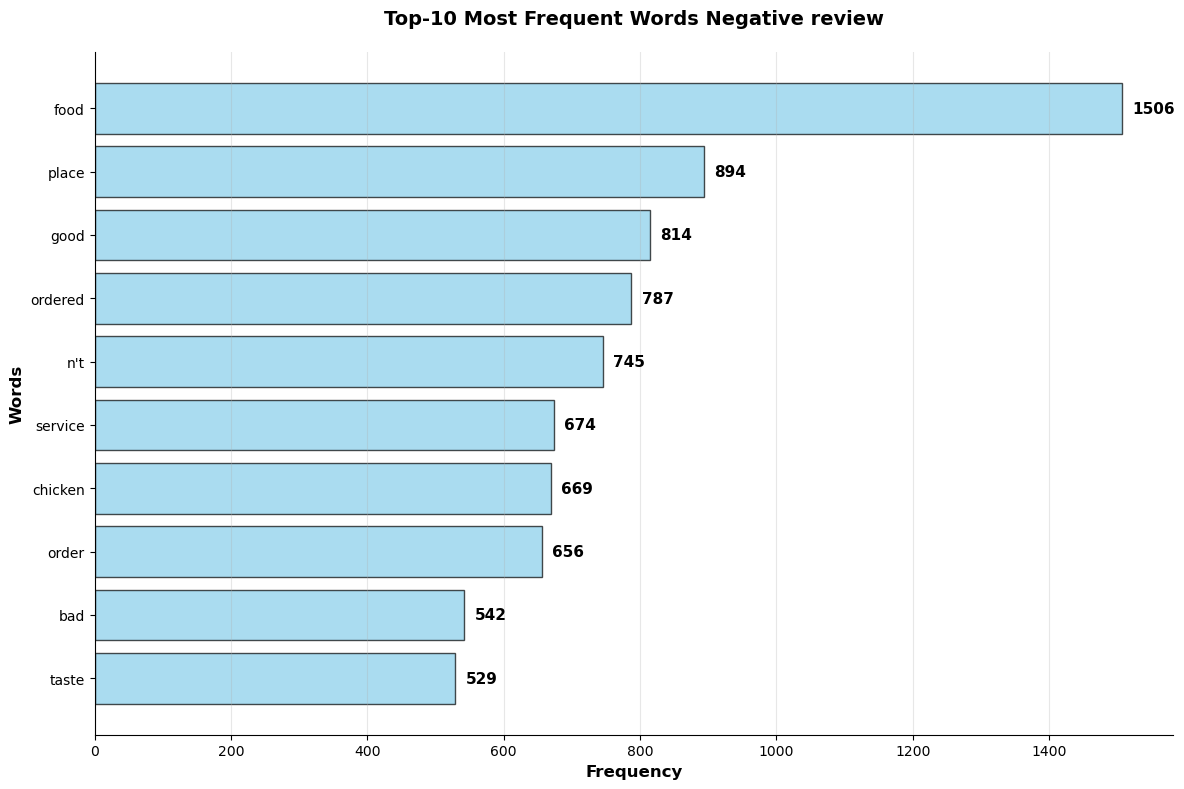

In [24]:
top_words_dict = plot_top_words_bar(processedData[processedData['Rating'] == 1], 'CleanReview', title='Negative review',top_n=10)

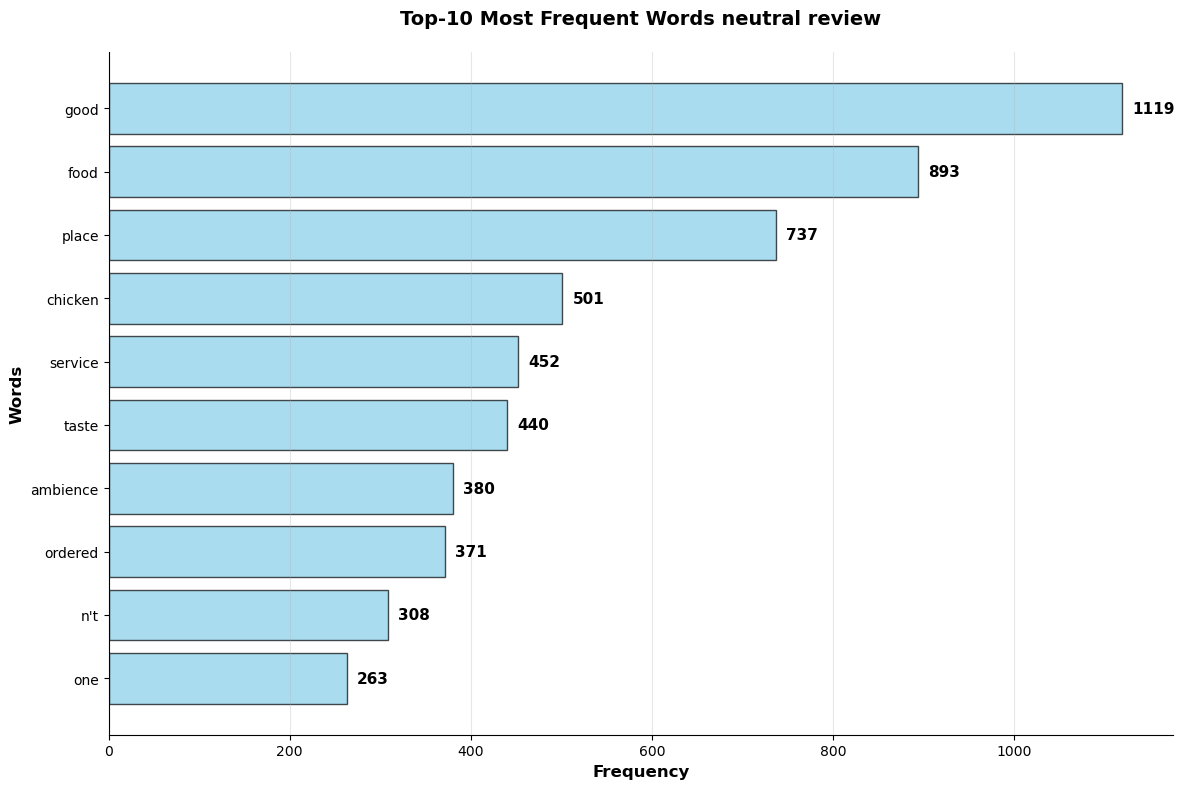

In [25]:
top_words_dict = plot_top_words_bar(processedData[processedData['Rating'] == 2], 'CleanReview', title= 'neutral review', top_n=10)

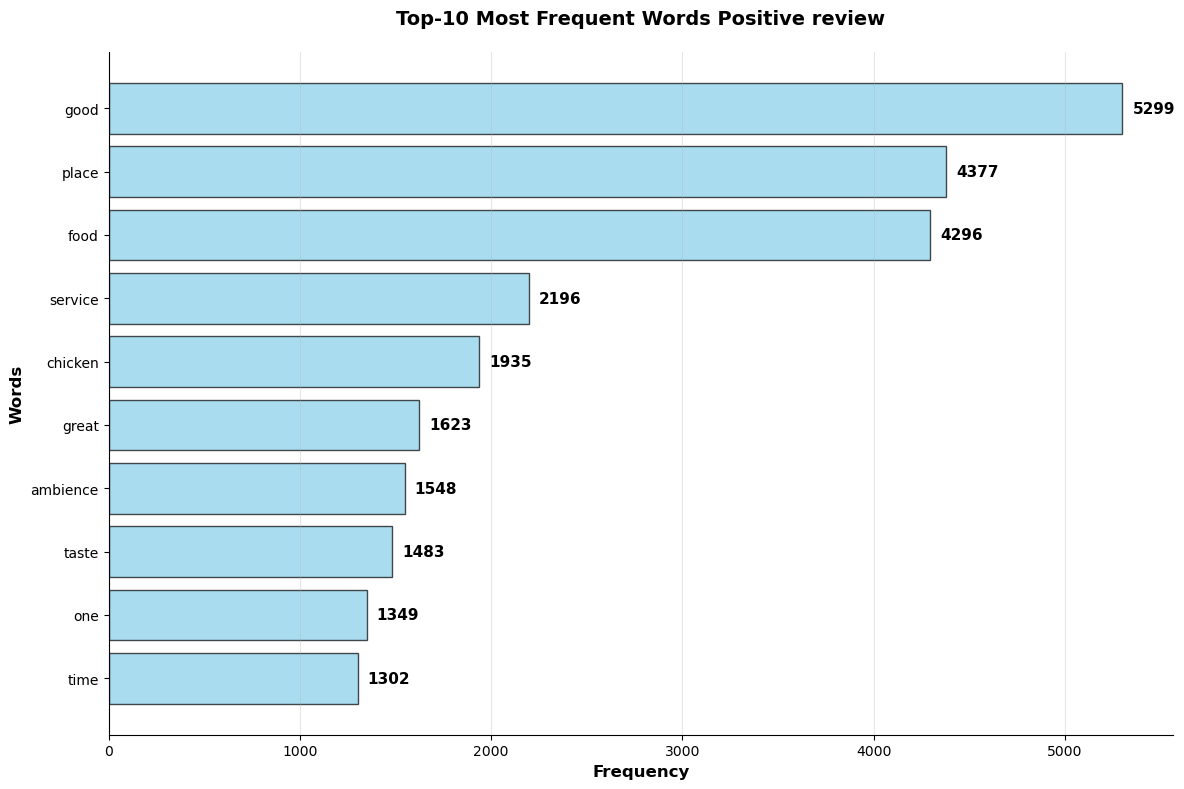

In [26]:
top_words_dict = plot_top_words_bar(processedData[processedData['Rating'] == 3], 'CleanReview',title='Positive review' ,top_n=10)

# ML 

В рамках данного проекта в качестве метрики будем использовать precision. Для бизнеса точкой роста являются негативные отзывы, в них больше информации для улучшений. Поэтому для нас важно уметь находить именно негативные отзывы с высокой точностью, а если не удастся детектировать все отызвы, то это не так критично.  

## Baseline Naive Bayes

In [27]:
results = {}

In [28]:
X, Y = processedData['CleanReview'], processedData['Rating']

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, random_state=42, train_size=0.2)

In [30]:
vectoriser = CountVectorizer()
X_train_vec = vectoriser.fit_transform(X_train)
X_test_vec = vectoriser.transform(X_test)

In [31]:
modelNB = MultinomialNB()
modelNB.fit(X_train_vec, Y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [32]:
def evaluate_model(model,X_test, y_test, model_name, avg='micro'):
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_test, y_pred, average=avg)
    recall = recall_score(y_test, y_pred, average=avg)
    f1 = f1_score(y_test, y_pred, average=avg)
    print(model_name)
    print(classification_report(y_pred, y_test))
    class_labels = np.unique(y_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return classification_report(y_pred, y_test, output_dict=True)
    

Naive Bayes
              precision    recall  f1-score   support

           1       0.73      0.83      0.78      1717
           2       0.06      0.37      0.10       148
           3       0.97      0.80      0.87      6135

    accuracy                           0.80      8000
   macro avg       0.59      0.67      0.58      8000
weighted avg       0.90      0.80      0.84      8000



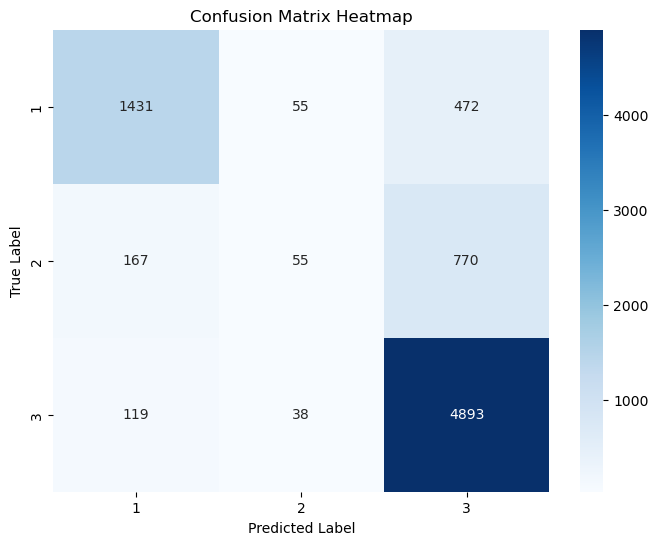

In [33]:
scoresNB = evaluate_model(modelNB, X_test_vec, Y_test, 'Naive Bayes', avg='macro')

In [34]:
results['NaiveB'] = scoresNB['macro avg']

## SVM

### BagOfWords

In [35]:
vectoriser = CountVectorizer()
X_train_BOF = vectoriser.fit_transform(X_train)
X_test_BOF = vectoriser.transform(X_test)

In [36]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_BOF, Y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


SVM
              precision    recall  f1-score   support

           1       0.70      0.70      0.70      1946
           2       0.25      0.27      0.26       924
           3       0.85      0.84      0.84      5130

    accuracy                           0.74      8000
   macro avg       0.60      0.60      0.60      8000
weighted avg       0.74      0.74      0.74      8000



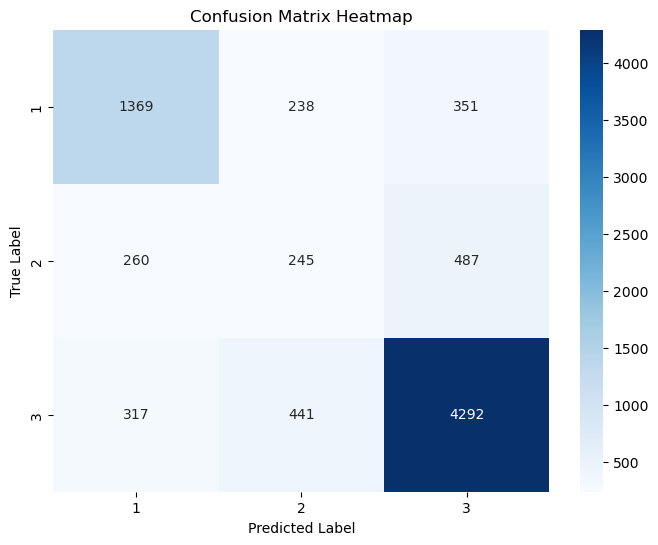

In [37]:
scoreSVM_BOF = evaluate_model(svm_classifier, X_test_BOF, Y_test, 'SVM', avg='macro')

In [38]:
results['SVM_BOF'] = scoreSVM_BOF['macro avg']

### TF-IDF

In [39]:
vectorizer = TfidfVectorizer()
X_train_TFIDF = vectorizer.fit_transform(X_train)
X_test_TFIDF = vectorizer.transform(X_test)

In [40]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_TFIDF, Y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


SVM_TFIDF
              precision    recall  f1-score   support

           1       0.77      0.79      0.78      1917
           2       0.07      0.40      0.11       162
           3       0.96      0.81      0.88      5921

    accuracy                           0.80      8000
   macro avg       0.60      0.67      0.59      8000
weighted avg       0.89      0.80      0.84      8000



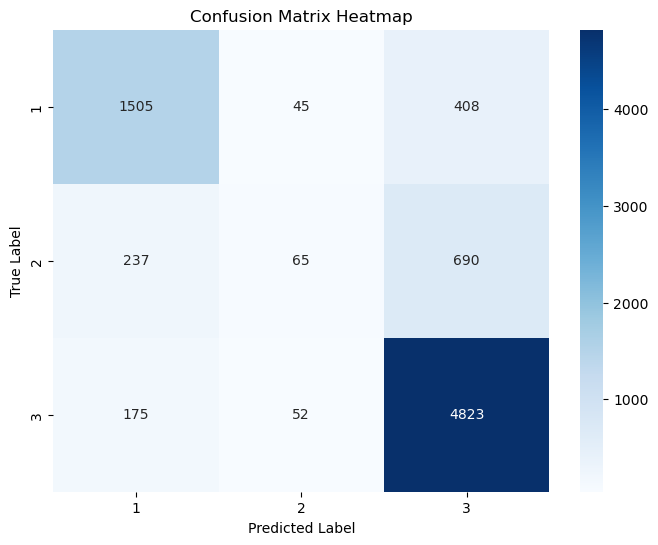

In [41]:
score_SVM_TFIDF = evaluate_model(svm_classifier, X_test_TFIDF, Y_test, avg='macro', model_name='SVM_TFIDF')

In [42]:
results['SVM_tf-idf'] = score_SVM_TFIDF['macro avg']

SVM не дал сильного прироста к результатам. TF-IDF позволил улучшить результаты относительно BOF.

## CatBoost for text

In [43]:
type(X_train)

pandas.core.series.Series

In [44]:
trainPool = Pool(data=X_train.to_frame(name='Text'), label=Y_train, text_features=['Text'])
testPool = Pool(data=X_test.to_frame(name='Text'), label=Y_test, text_features=['Text'])


In [45]:
modelCB = CatBoostClassifier(
    loss_function='MultiClass', 
    verbose=100,
    random_seed=42
)

In [46]:
modelCB.fit(trainPool)

Learning rate set to 0.081974
0:	learn: 1.0238654	total: 490ms	remaining: 8m 9s
100:	learn: 0.5146336	total: 29.3s	remaining: 4m 21s
200:	learn: 0.4574936	total: 57.7s	remaining: 3m 49s
300:	learn: 0.4218008	total: 1m 23s	remaining: 3m 15s
400:	learn: 0.3928643	total: 1m 50s	remaining: 2m 44s
500:	learn: 0.3694800	total: 2m 19s	remaining: 2m 19s
600:	learn: 0.3488995	total: 2m 48s	remaining: 1m 51s
700:	learn: 0.3305341	total: 3m 16s	remaining: 1m 23s
800:	learn: 0.3140184	total: 3m 45s	remaining: 55.9s
900:	learn: 0.2993158	total: 4m 13s	remaining: 27.8s
999:	learn: 0.2861160	total: 4m 37s	remaining: 0us


CatBoost
              precision    recall  f1-score   support

           1       0.79      0.80      0.80      1951
           2       0.09      0.40      0.14       216
           3       0.95      0.82      0.88      5833

    accuracy                           0.81      8000
   macro avg       0.61      0.67      0.61      8000
weighted avg       0.89      0.81      0.84      8000



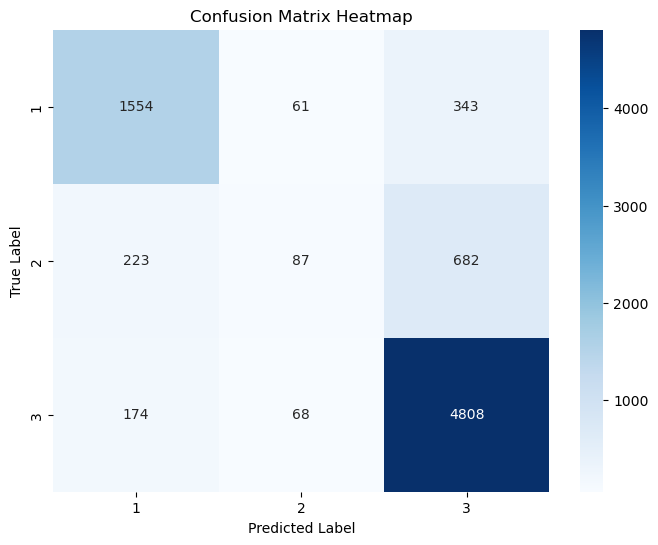

In [47]:
score_cb = evaluate_model(modelCB, testPool, Y_test, 'CatBoost')

In [48]:
results['CatBoost'] = score_cb['macro avg']

CatBoost не дал сильного прироста результатов. Скорее всего ему не хватило данных. Таким образом на маленьких датасетах, catBoost не даст сильного прироста.

## Deep Learning

In [94]:
import gensim.downloader as api
ft_model = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [95]:
def getEmbeddings(text, model= ft_model):
    words = text.split()
    if not words:
        return np.zeros(ft_model.vector_size)
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
    return np.mean(vectors, axis=0)
    
    

In [107]:
dataNN = processedData
dataNN.dropna(inplace=True)
dataNN['embeddings'] = dataNN['CleanReview'].apply(getEmbeddings)
dataNN = dataNN[dataNN['embeddings'].apply(lambda x: sum(x) > 0)]
dataNN.to_csv('data/datasetNN.csv', index=False)


In [108]:
dataNN = pd.read_csv('data/datasetNN.csv')

In [110]:
X_train, X_test, Y_train, Y_test = train_test_split(dataNN['embeddings'], dataNN['Rating'], stratify=dataNN['Rating'], test_size=0.2)

### Classical MLP over fasttext embeddings 